In [ ]:
# Install required libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.17.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the text dataset from Kaggle

In [ ]:
# Input the below code
!pip install kaggle --upgrade

In [ ]:
from google.colab import files
files.upload()
# Upload the file kaggle.json after clicking the selection button

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lloydkimyg","key":"0ce28b39e913f50181a16b7249dc6a0d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls -1ha kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 80% 65.0M/80.9M [00:00<00:00, 163MB/s]
100% 80.9M/80.9M [00:00<00:00, 173MB/s]


In [ ]:
from zipfile import ZipFile
file_name = 'sentiment140.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall('/content')
  print('Done')

Done


## Data Preprocessing

In [ ]:
# Read the csv file
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding='latin', header=None)
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Drop unnecessary features
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [ ]:
# Create a function to convert numeric values to categorical ones in the sentiment column
# We use only two sentiments excluding neutral one.
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


We can see the distribution of classes of the sentiment column.

Text(0.5, 1.0, 'Sentiment Data Distribution')

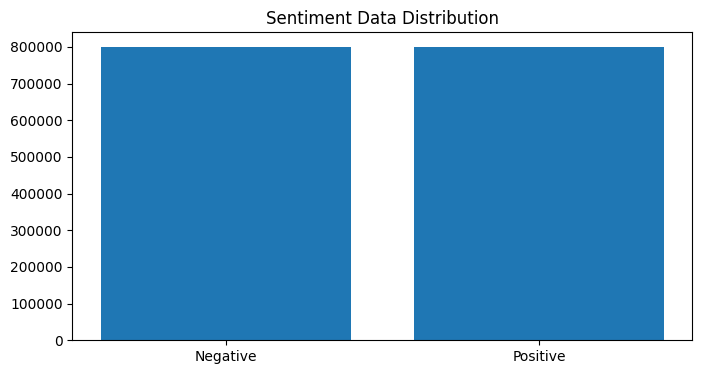

In [ ]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

There is no skewness of the sentiment data.

### Data Cleansing

Tweet texts contain other user mentions, hyperlink texts, emojis and puctuations. We cannot use them for using a Language Model without excluding the unnecessary texts. So we have to clean the text data using various preprocessing methods. We are going to use the following methods:
1) Stemming / Lematization
2) Excluding hyperlinks / other user mentions(@)
3) Excluding stopwords

NLTK is python library which got functions to perform text preprocessing task for NLP.

In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
# Create a function to use stemming, exclude stopwords, and eliminate other unnecessary texts
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [ ]:
df.text = df.text.apply(lambda x: preprocess(x))

#### Word cloud for positive words

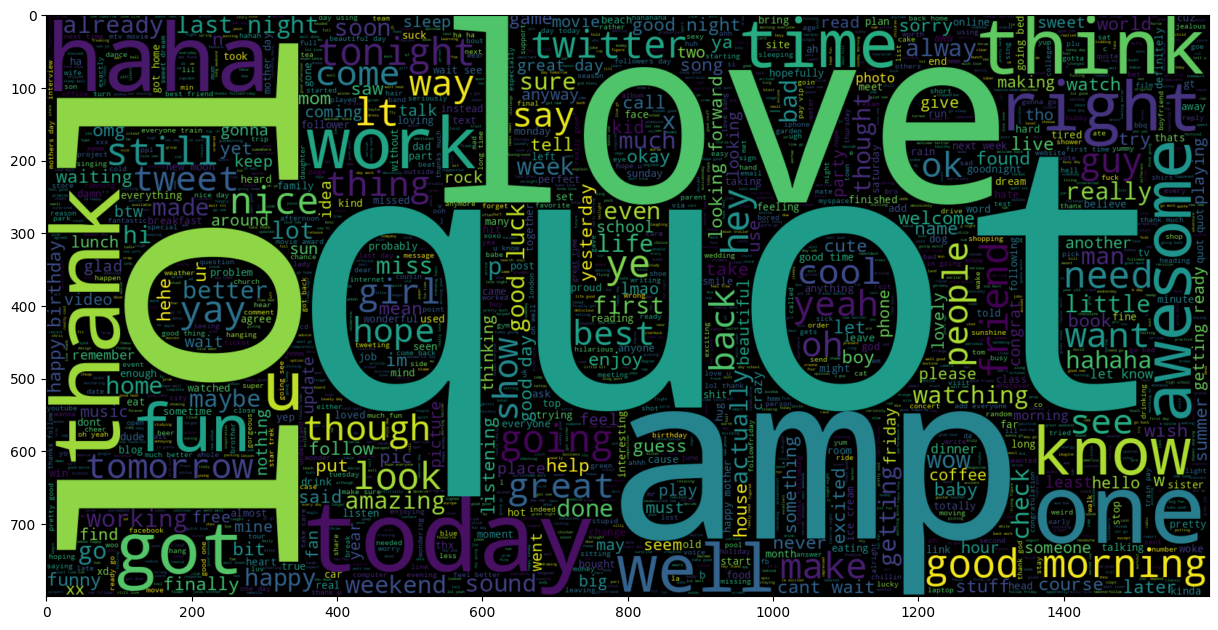

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

#### Word cloud for negative words

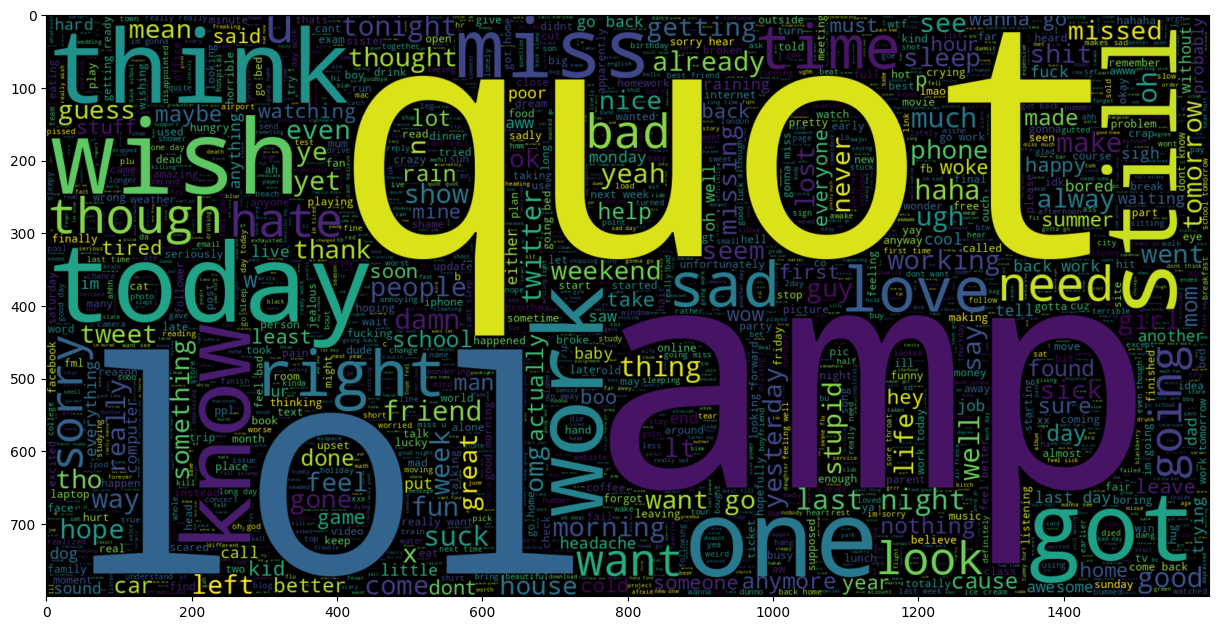

In [ ]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

## Spliting the dataset

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42) # Split the dataset into training and test datasets
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [ ]:
train_data.sample(10) # Returns the 10 rows with the index and display it

,sentiment,text
1440525,Positive,last tweet tony la russa cut
1440998,Positive,nice
1322714,Positive,true time purpose
313716,Negative,hi carisa thought write comment working paper ...
232815,Negative,oooh pretty im hungry grr sunday back school 2...
336226,Negative,yeah know always getting mad way talks get ann...
52797,Negative,stupid wearin white shirt work
1115438,Positive,think got slacker past weeks right w mush brai...
605162,Negative,txt received o2 due respect o2 simply good qui...
22747,Negative,mcfly playing goes another one ucap tour


## Tokenization

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290419


Now we got a tokenizer object, which can be used to covert any word into a Key in dictionary (number).

Since we are going to build a sequence model. We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same length. But texts in tweets have different count of words in it. To avoid this, we seek a little help from pad_sequence to do our job. It will make all the sequence in one constant length MAX_SEQUENCE_LENGTH.

In [ ]:
from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 50

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 50)
Testing X Shape: (320000, 50)


In [ ]:
labels = train_data.sentiment.unique().tolist() # "Positive" + "Negative"

## Label Encoding

We are building a model to predict class in enocoded form (0 or 1, as this is a binary classification). We should encode our training labels accordingly.


In [ ]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


## Spliting the dataset into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

## Model Training - RNN with word embedding

In [ ]:
# Write code for a simple recurrent neural network using Keras' Sequential class. Also, add Word Embedding
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=MAX_SEQUENCE_LENGTH))
model.add(keras.layers.SimpleRNN(8)) #뉴런의 개수: 8
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-3) # Increase the learning rate from 0.0001 to  0.001 according to the higher batch size
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=50, batch_size=512, # Increase the batch size to improve computational efficiency
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 53s 25ms/step - accuracy: 0.6893 - loss: 0.5755 - val_accuracy: 0.7170 - val_loss: 0.5431
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 84s 26ms/step - accuracy: 0.7188 - loss: 0.5403 - val_accuracy: 0.7196 - val_loss: 0.5378
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 79s 25ms/step - accuracy: 0.7189 - loss: 0.5378 - val_accuracy: 0.7204 - val_loss: 0.5366
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - accuracy: 0.7202 - loss: 0.5356 - val_accuracy: 0.7192 - val_loss: 0.5375
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 48s 24ms/step - accuracy: 0.7213 - loss: 0.5350 - val_accuracy: 0.7209 - val_loss: 0.5359
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 84s 25ms/step - accuracy: 0.7215 - loss: 0.5344 - val_accuracy: 0.7204 - val_loss: 0.5366
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 80s 24ms/step - accuracy: 0.7204 - loss: 0.5355 - val_accuracy: 0.7201 - val_loss: 0.5362
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 83s 25ms/step - accuracy: 0.7215 -

In [ ]:
# Print the model structure
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (512, 50, 16)               │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_12 (SimpleRNN)            │ (512, 8)                    │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (512, 1)                    │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,420 (64.14 KB)

 Trainable params: 8,209 (32.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,211 (32.08 KB)

The training stopped at the 8th epoch. The validation accuracy is around 72%. Although the accuracy is moderate, we can apply other methods to get a more accurate score.

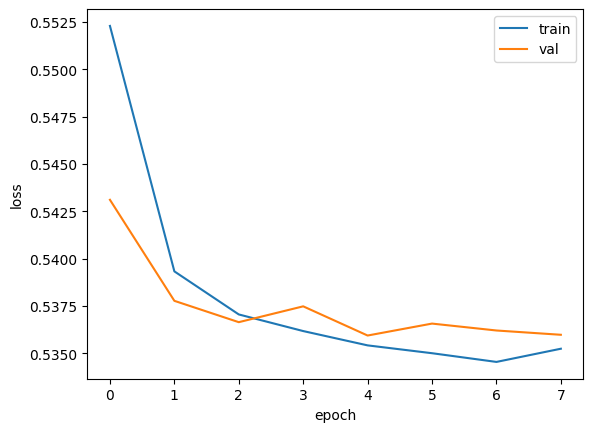

In [ ]:
# Plot the graph of training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## LSTM



In [ ]:
# Create a recurrent layer using LSTM cells
from tensorflow import keras
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=MAX_SEQUENCE_LENGTH))
model2.add(keras.layers.LSTM(8, dropout=0.4)) # SimpleRNN 클래스 대신 LSTM 클래스로 치환하기, dropout 40%
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
# Compile and train the model
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-3)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model2.fit(x_train, y_train, epochs=50, batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 85s 41ms/step - accuracy: 0.6837 - loss: 0.5912 - val_accuracy: 0.7174 - val_loss: 0.5424
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 143s 42ms/step - accuracy: 0.7180 - loss: 0.5435 - val_accuracy: 0.7189 - val_loss: 0.5390
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 141s 41ms/step - accuracy: 0.7175 - loss: 0.5422 - val_accuracy: 0.7195 - val_loss: 0.5373
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.7182 - loss: 0.5398 - val_accuracy: 0.7202 - val_loss: 0.5357
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accuracy: 0.7192 - loss: 0.5384 - val_accuracy: 0.7203 - val_loss: 0.5347
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accuracy: 0.7191 - loss: 0.5379 - val_accuracy: 0.7206 - val_loss: 0.5362
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 147s 44ms/step - accuracy: 0.7198 - loss: 0.5369 - val_accuracy: 0.7222 - val_loss: 0.5346
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 140s 43ms/step - accuracy: 0.71

In [ ]:
model2.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (512, 50, 16)               │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (512, 8)                    │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (512, 1)                    │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,620 (68.83 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,811 (34.42 KB)

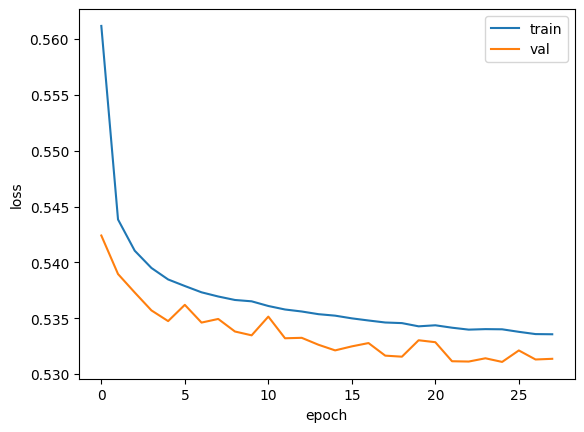

In [ ]:
# Plot the training loss and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

The accuracy rate of the model 2 is 72.4%. which is a little higher than that of the model 1.

## GRU (Gated Recurrent Unit)

In [ ]:
# Train a GRU neural network
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length=MAX_SEQUENCE_LENGTH))
model3.add(keras.layers.GRU(8)) # Replace the LSTM class with the GRU class
model3.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
# Train a recurrent neural network using GRU cells.
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-3)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model3.fit(x_train, y_train, epochs=50, batch_size=512,
                     validation_data=(x_val, y_val),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 111s 54ms/step - accuracy: 0.6902 - loss: 0.5782 - val_accuracy: 0.7183 - val_loss: 0.5399
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 141s 54ms/step - accuracy: 0.7181 - loss: 0.5395 - val_accuracy: 0.7202 - val_loss: 0.5361
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 138s 52ms/step - accuracy: 0.7209 - loss: 0.5354 - val_accuracy: 0.7224 - val_loss: 0.5333
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 137s 49ms/step - accuracy: 0.7233 - loss: 0.5316 - val_accuracy: 0.7237 - val_loss: 0.5318
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 95s 48ms/step - accuracy: 0.7238 - loss: 0.5308 - val_accuracy: 0.7252 - val_loss: 0.5304
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 142s 47ms/step - accuracy: 0.7252 - loss: 0.5296 - val_accuracy: 0.7249 - val_loss: 0.5298
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 94s 47ms/step - accuracy: 0.7259 - loss: 0.5282 - val_accuracy: 0.7251 - val_loss: 0.5294
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 148s 50ms/step - accuracy: 0.

In [ ]:
model3.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ (512, 50, 16)               │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (512, 8)                    │             624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (512, 1)                    │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,268 (67.46 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,635 (33.73 KB)

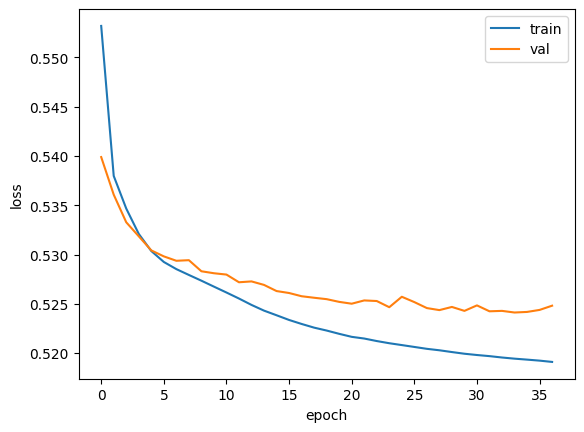

In [ ]:
# Plot the training loss and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

The validation accuracy is around 72.87%, which is the best performance.

## Train the dataset using the best model

In [ ]:
# Load the best-gru-model
rnn_model = keras.models.load_model('best-gru-model.keras')
rnn_model.evaluate(x_test, y_test)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 67s 7ms/step - accuracy: 0.7292 - loss: 0.5241


[0.5244411826133728, 0.7289437651634216]

The test accuracy is almost the same as the validation accuracy.